In [1]:
import os
import sys

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Standard Imports
import pandas as pd
import h5py
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import pathlib
import tensorflow as tf
from keras import metrics
from keras.constraints import max_norm
# gpus = tf.config.experimental.list_physical_devices("GPU")
path = pathlib.Path.cwd()

In [2]:
# Import homemade tools
from get_data import get_data
from get_model import get_model
from get_data_raw import get_data as get_data_raw
from mean_ci import mean_ci
from get_best_sherpa_result import get_best_sherpa_result
from run_bootstrap import run_bootstraps

In [18]:
rinv = '1p0'

In [4]:
path

PosixPath('/local_disk/james/Taylor_data/semi-visible-jets-ml/NN_training')

In [19]:
# model_fl = './bootstrap_results/LL/'+rinv+'/models/bs_0.h5'
model_fl = './bootstrap_results/HL/'+rinv+'/models/bs_0.h5'

# model_fl = '../../Train/Keras_Tunner/CNN3_all_0p3_Adam_filter_preprocessing/'
# model_fl = '../../Train/Keras_Tunner/CNN3_0p0_Adam_filter/'
# model_fl = './CNN3_all_'+rinv+'_Adam_filter_preprocessing/'




In [20]:
model = tf.keras.models.load_model(model_fl)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 185)               2590      
_________________________________________________________________
dropout (Dropout)            (None, 185)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 185)               34410     
_________________________________________________________________
dropout_1 (Dropout)          (None, 185)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 185)               34410     
_________________________________________________________________
dropout_2 (Dropout)          (None, 185)               0

In [21]:
X, Y = get_data("HL", rinv)
X = np.nan_to_num(X)
# X, Y = get_data("LL", rinv)


In [22]:
N = len(X)
Ntrain, Nval, Ntest = int(N/5*4),  int(N/10),  int(N/10)
Xim_train, Xim_val, Xim_test = X[:Ntrain], X[Ntrain:Nval+Ntrain], X[Nval+Ntrain:N]
yim_train, yim_val, yim_test = Y[:Ntrain], Y[Ntrain:Nval+Ntrain], Y[Nval+Ntrain:N]

In [10]:
from sklearn.metrics import roc_curve, auc


The area under the curves are:
AUC:0.267092490
AUC:0.732907510


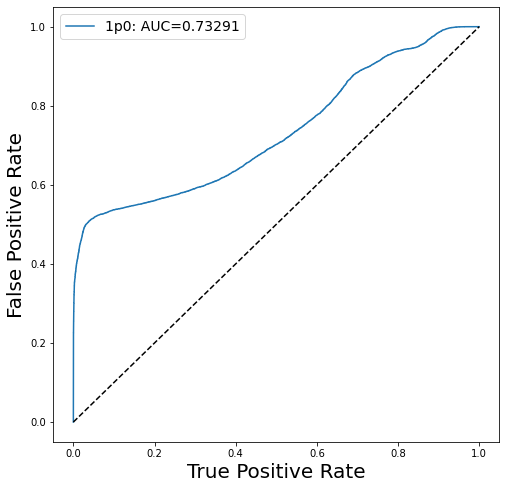

In [23]:
y_score=model.predict(Xim_test)[:,0]
y_score = np.hstack(y_score)
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( yim_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
if roc_auc<0.5:
    a = tpr
    tpr = fpr
    fpr = a
    roc_auc = 1 - roc_auc
    print("AUC:{0:.9f}".format(roc_auc))
    
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,8))
plt.plot(tpr,fpr, label=rinv+': AUC={0:.5f}'.format(roc_auc))

# plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.5f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.legend()
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)

plt.legend(prop={'size': 14})



# plt.savefig("./Keras_Tunner/check_CNN3_all_"+rinv+"_filter_roc_preprocessing.png")
plt.savefig("./DNN3_all_"+rinv+"_Taylor.png")

# hf = h5py.File("./Keras_Tunner/PR_all_"+rinv+"_"+optn+"_filter_preprocessing.h5", 'w')
# hf = h5py.File("./Keras_Tunner/PR3_all_"+rinv+"_"+optn+"_filter_preprocessing.h5", 'w')
hf = h5py.File("./Taylor_PR3_all_"+rinv+".h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()


plt.show()

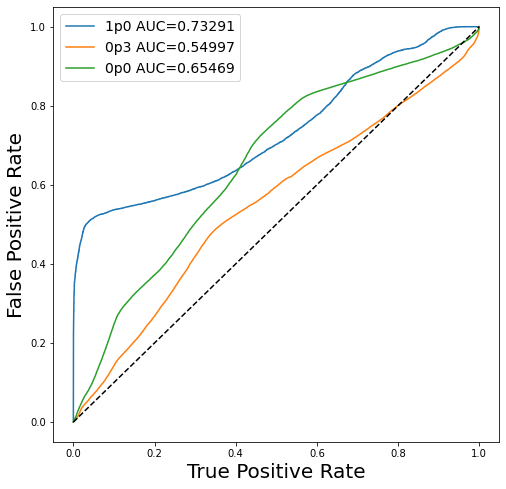

In [24]:
rinvs = ["1p0", "0p3", "0p0" ]
plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
for rinv in rinvs:
    hf = h5py.File("./Taylor_PR3_all_"+rinv+".h5",'r')
    fpr = hf["fpr"][:]
    tpr = hf["tpr"][:]
    roc_auc = auc(tpr,fpr )
    plt.plot(tpr,fpr, label=rinv+' AUC={0:.5f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.legend()
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)

plt.legend(prop={'size': 14})

plt.savefig("./Taylor_DNN_all_roc.png")
plt.show()

In [ ]:
def run_bootstraps(run_type, rinv):
    # Trainig parameters from the sherpa optimization
    tp = get_best_sherpa_result(run_type, rinv)
    X, y = get_data(run_type, rinv)

    rs = ShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.10)
    rs.get_n_splits(X)
    ShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.10)
    straps = []
    aucs = []
    boot_ix = 0
    t = tqdm(list(rs.split(X)))

    for train_index, test_index in t:
        X_train = X[train_index]
        y_train = y[train_index]
        X_val = X[test_index]
        y_val = y[test_index]

        if run_type == "HL":
            input_shape = X_train.shape[1]
        else:
            input_shape = None

        bs_path = path / "bootstrap_results" / run_type / rinv
        model_file = bs_path / "models" / f"bs_{boot_ix}.h5"
        roc_file = bs_path / "roc" / f"roc_{boot_ix}.csv"
        ll_pred_file = bs_path / "ll_predictions" / f"pred_{boot_ix}.npy"

        if not bs_path.parent.exists():
            os.mkdir(bs_path.parent)
        if not bs_path.exists():
            os.mkdir(bs_path)
        if not model_file.parent.exists():
            os.mkdir(model_file.parent)
        if not roc_file.parent.exists():
            os.mkdir(roc_file.parent)
        if not ll_pred_file.parent.exists():
            os.mkdir(ll_pred_file.parent)

        if not model_file.exists():
            model = get_model(run_type, tp, input_shape)
            callbacks = [
                keras.callbacks.EarlyStopping(
                    monitor="val_auc",
                    patience=10,
                    min_delta=0.0001,
                    verbose=0,
                    restore_best_weights=True,
                    mode="max",
                ),
                keras.callbacks.ModelCheckpoint(
                    filepath=model_file, verbose=0, save_best_only=True
                ),
            ]

            model.fit(
                X_train,
                y_train,
                epochs=epochs,
                verbose=2,
                batch_size=int(tp["batch_size"]),
                validation_data=(X_val, y_val),
                callbacks=callbacks,
            )

        else:
            model = keras.models.load_model(model_file)

        val_predictions = np.hstack(model.predict(X_val))
        auc_val = roc_auc_score(y_val, val_predictions)

        # Save the predictions
        np.save(ll_pred_file, model.predict(X))

        straps.append(boot_ix)
        aucs.append(auc_val)

        fpr, tpr, _ = roc_curve(y_val, val_predictions)
        background_efficiency = fpr
        signal_efficiency = tpr
        background_rejection = 1.0 - background_efficiency

        roc_df = pd.DataFrame(
            {
                "sig_eff": signal_efficiency,
                "bkg_eff": background_efficiency,
                "bkg_rej": background_rejection,
            }
        )
        roc_df.to_csv(roc_file)

        results = pd.DataFrame({"bs": straps, "auc": aucs})
        results.to_csv(bs_path / "aucs.csv")
        auc_mean, auc_ci = mean_ci(aucs)
        boot_ix += 1
        t.set_description(
            f"rinv={rinv} ({boot_ix}/{n_splits}): (AUC = {auc_mean:.4f} +/- {auc_ci:.4f})"
        )
        t.refresh()

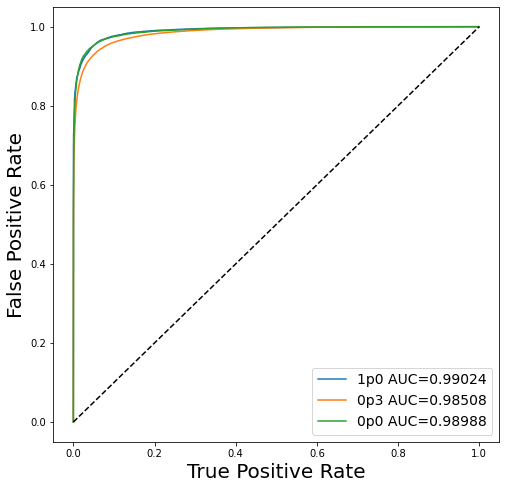

In [19]:
rinvs = ["1p0", "0p3", "0p0" ]
plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
for rinv in rinvs:
    hf = h5py.File("./PR3_all_"+rinv+"_Adam_filter_preprocessing.h5",'r')
    fpr = hf["fpr"][:]
    tpr = hf["tpr"][:]
    roc_auc = auc(tpr,fpr )
    plt.plot(tpr,fpr, label=rinv+' AUC={0:.5f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.legend()
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)

plt.legend(prop={'size': 14})

plt.savefig("./Keras_Tunner/CNN_all_tune_filters_all_roc.png")
plt.show()